<h3>Report</h3>

In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
import seaborn as sns

<h3>Loading Models</h3>

In [3]:
from core.network import *
from core.trainer import *
from core.visualization import *

In [4]:
device = torch.device("cuda:0")
dir_load = '../models/'

In [5]:
net = LSTM(1, 98, 9, num_layers=3, device=device).to(device)
model = LSTMTrainer(net, device=device)
model2 = LSTMTrainer(net, device=device)

<h3>Dataloading for Eval</h3>

In [6]:
ligands = ["TNF", "R84", "PIC", "P3K", "FLA", "CpG", "FSL", "LPS", "UST"]
polarization = ["", "ib", "ig", "i0", "i3", "i4"]
replicas, size = 2, 1288

In [7]:
from core.getdata import *
from core.dataset import * 
from core.dataset2 import *

In [8]:
data = DatasetPolar(ligands, polarization, replicas, size)
data2 = DatasetNaive(ligands, replicas, size)

In [9]:
from torch.utils.data import Dataset
from torchvision import datasets

In [10]:
print(len(data), 0.25 * len(data)) # we'll test our data on 25% of the dataset
print(len(data2), 0.25 * len(data2))

69552 17388.0
11592 2898.0


In [11]:
_, datatest = torch.utils.data.random_split(data, [69552 - 17388 - 24, 17388 + 24])
_, dataset2 = torch.utils.data.random_split(data2, [11592 - 2880, 2880]) # 302
testloader = torch.utils.data.DataLoader(datatest, batch_size=32, shuffle=True)
testloader2 = torch.utils.data.DataLoader(dataset2, batch_size=16, shuffle=True)

<h3>Evaluation Loop</h3>

In [12]:
model.load(dir_load + 'lstm1.pth') # polarized

In [13]:
polarization_true, polarization_pred, polarized_prob = np.empty([32,]).T, np.empty([32,]).T, np.empty([32,9])

In [14]:
for x, y in testloader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    polarization_true = np.hstack([polarization_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    # y_prob = np.amax(y_pred, axis=1)
    # import pdb; pdb.set_trace()
    polarized_prob = np.vstack([polarized_prob, y_pred])
    y_pred = np.argmax(y_pred, axis=1)
    polarization_pred = np.hstack([polarization_pred, y_pred.T])
    #y_true = (32, ); y_pred = (32, ); y_prob = (32, 9)

In [15]:
model2.load(dir_load + 'lstm.pth') # naive

In [16]:
naive_true, naive_pred, naive_prob = np.empty([16,]).T, np.empty([16,]).T, np.empty([16,9])

In [17]:
for x2, y2 in testloader2:
    x2, y2 = x2.to(device), y2.to(device)
    y_true = y2.detach().cpu().numpy()
    naive_true = np.hstack([naive_true, y_true.T])
    y_pred = model2.network(x2)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    # y_prob = np.amax(y_pred, axis=1)
    naive_prob = np.vstack([naive_prob, y_pred])
    y_pred = np.argmax(y_pred, axis=1)
    #import pdb; pdb.set_trace()
    naive_pred = np.hstack([naive_pred, y_pred.T])
    #y_true = (16, ); y_pred = (16, ); y_prob = (16, 9)

In [18]:
polarization_true, polarization_pred, polarized_prob = polarization_true[32:], polarization_pred[32:], polarized_prob[32:]
naive_true, naive_pred, naive_prob = naive_true[16:], naive_pred[16:], naive_prob[16:]
print(naive_true.shape, naive_pred.shape, polarization_true.shape, polarization_pred.shape, polarized_prob.shape, naive_prob.shape)

(2880,) (2880,) (17412,) (17412,) (17412, 9) (2880, 9)


In [19]:
comparison = np.vstack([polarization_true, polarization_pred]).T
comparison2 = np.vstack([naive_true, naive_pred]).T

In [20]:
df, df2 = pd.DataFrame(comparison), pd.DataFrame(comparison2)

In [21]:
print(df)

         0    1
0      3.0  3.0
1      0.0  0.0
2      2.0  2.0
3      8.0  8.0
4      5.0  5.0
...    ...  ...
17407  6.0  6.0
17408  0.0  0.0
17409  8.0  8.0
17410  8.0  8.0
17411  1.0  1.0

[17412 rows x 2 columns]


In [22]:
print(df2)

        0    1
0     5.0  5.0
1     2.0  2.0
2     3.0  3.0
3     8.0  8.0
4     7.0  7.0
...   ...  ...
2875  1.0  1.0
2876  2.0  2.0
2877  8.0  8.0
2878  0.0  0.0
2879  1.0  1.0

[2880 rows x 2 columns]


<h3>Naive/Polarized Metrics</h3>

In [23]:
# ACCURACY
print(f' Naive Accuracy: {sum(df2[0] == df2[1])/2880} \n Polarized Accuracy: {sum(df[0] == df[1])/17412}')

 Naive Accuracy: 0.9565972222222222 
 Polarized Accuracy: 0.9165518033540088


In [24]:
naive_report = sklearn.metrics.classification_report(df2[0], df2[1], target_names=ligands, output_dict=True)
naive_rep = pd.DataFrame(naive_report).transpose()

polarized_report = sklearn.metrics.classification_report(df[0], df[1], target_names=ligands, output_dict=True)
polarized_rep = pd.DataFrame(polarized_report).transpose()

In [25]:
print(naive_rep)

              precision    recall  f1-score      support
TNF            0.961765  0.979042  0.970326   334.000000
R84            0.983108  0.863501  0.919431   337.000000
PIC            0.990741  0.975684  0.983155   329.000000
P3K            0.930636  0.978723  0.954074   329.000000
FLA            0.944099  0.944099  0.944099   322.000000
CpG            0.947712  0.963455  0.955519   301.000000
FSL            0.926154  0.952532  0.939158   316.000000
LPS            0.953560  0.968553  0.960998   318.000000
UST            0.976510  0.989796  0.983108   294.000000
accuracy       0.956597  0.956597  0.956597     0.956597
macro avg      0.957143  0.957265  0.956652  2880.000000
weighted avg   0.957265  0.956597  0.956355  2880.000000


In [26]:
print(polarized_rep)

              precision    recall  f1-score       support
TNF            0.938664  0.883050  0.910008   1941.000000
R84            0.944763  0.909228  0.926655   1994.000000
PIC            0.929535  0.957775  0.943444   1942.000000
P3K            0.900254  0.917531  0.908811   1928.000000
FLA            0.868077  0.893727  0.880715   1929.000000
CpG            0.882597  0.898942  0.890695   1890.000000
FSL            0.884422  0.898876  0.891591   1958.000000
LPS            0.906638  0.888889  0.897676   1890.000000
UST            0.996405  1.000000  0.998199   1940.000000
accuracy       0.916552  0.916552  0.916552      0.916552
macro avg      0.916817  0.916447  0.916421  17412.000000
weighted avg   0.917043  0.916552  0.916586  17412.000000


In [27]:
polarizedf1, naivef1, totalf1 = polarized_rep[:9], naive_rep[:9], pd.concat([polarized_rep[:9], naive_rep[:9]], axis=1)

<h4>F1 Polarized Ligands</h4>

<AxesSubplot:>

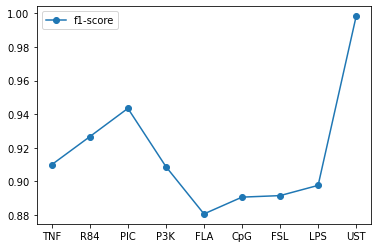

In [28]:
polarizedf1.plot(y='f1-score', style='o-')

<h4>F1 Naive Ligands</h4>

<AxesSubplot:>

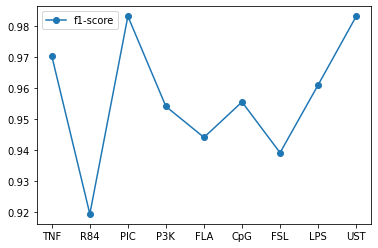

In [29]:
naivef1.plot(y='f1-score', style='o-')

<h4>F1 Ligands</h4>

<AxesSubplot:>

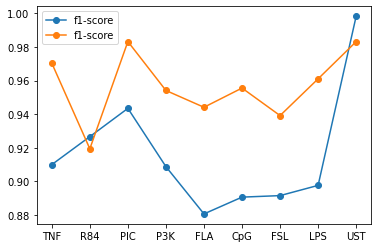

In [30]:
totalf1.plot(y='f1-score', style='o-') # orange: naive | blue: polarized

In [31]:
polarized_confusion = sklearn.metrics.confusion_matrix(df[0], df[1])
pccm = sklearn.metrics.ConfusionMatrixDisplay(polarized_confusion)

naive_confusion = sklearn.metrics.confusion_matrix(df2[0], df2[1])
nccm = sklearn.metrics.ConfusionMatrixDisplay(naive_confusion)

polarized_fraction = Fraction(polarization_true, polarized_prob)
naive_fraction = Fraction(naive_true, naive_prob)

<h4>Naive Confusion Matrix/Fraction</h4>

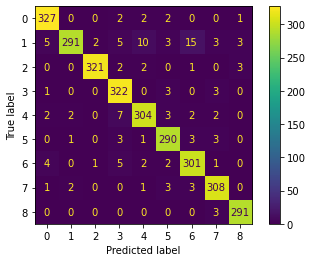

In [32]:
nccm.plot()

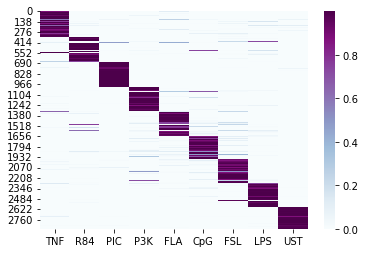

In [33]:
ncf = sns.heatmap(naive_fraction, cmap="BuPu", xticklabels=ligands) # BuPu, mako, magma

<h4>Polarized Confusion Matrix/Fraction</h4>

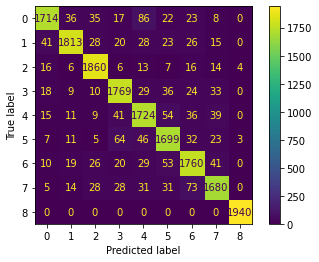

In [34]:
pccm.plot()

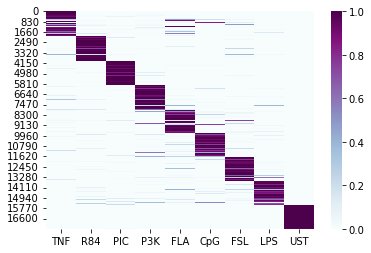

In [35]:
pcf = sns.heatmap(polarized_fraction, cmap="BuPu", xticklabels=ligands) # BuPu, mako, magma

In [36]:
# pcfm.plot()

<h3>Polarization State Analysis</h3>

In [37]:
ligands = ["TNF", "R84", "PIC", "P3K", "FLA", "CpG", "FSL", "LPS", "UST"]
polarization = ["", "ib", "ig", "i0", "i3", "i4"]
replicas, size = 2, 1288

In [38]:
unpolarized_data = DatasetPolar(ligands, [""], replicas, size)
ib = DatasetPolar(ligands, ["ib"], replicas, size)
ig = DatasetPolar(ligands, ["ig"], replicas, size)
i0 = DatasetPolar(ligands, ["i0"], replicas, size)
i3 = DatasetPolar(ligands, ["i3"], replicas, size)
i4 = DatasetPolar(ligands, ["i4"], replicas, size)

In [39]:
print(len(unpolarized_data) + len(ib) + len(ig) + len(i0) + len(i3) + len(i4))
print(len(i4))

69552
11592


In [40]:
_, unpolarizedtest = torch.utils.data.random_split(unpolarized_data, [11592 - 3200, 3200])
_, ibtest = torch.utils.data.random_split(ib, [11592 - 3200, 3200])
_, igtest = torch.utils.data.random_split(ig, [11592 - 3200, 3200])
_, i0test = torch.utils.data.random_split(i0, [11592 - 3200, 3200])
_, i3test = torch.utils.data.random_split(i3, [11592 - 3200, 3200])
_, i4test = torch.utils.data.random_split(i4, [11592 - 3200, 3200])

uploader = torch.utils.data.DataLoader(unpolarizedtest, batch_size=32, shuffle=True)
ibloader = torch.utils.data.DataLoader(ibtest, batch_size=32, shuffle=True)
igloader = torch.utils.data.DataLoader(igtest, batch_size=32, shuffle=True)
i0loader = torch.utils.data.DataLoader(i0test, batch_size=32, shuffle=True)
i3loader = torch.utils.data.DataLoader(i3test, batch_size=32, shuffle=True)
i4loader = torch.utils.data.DataLoader(i4test, batch_size=32, shuffle=True)

<h3>Evaluation Loop</h3>

In [41]:
model.load(dir_load + 'lstm1.pth') # polarized

In [42]:
up_true, up_pred, up_prob = np.empty([32,]), np.empty([32,]), np.empty([32, 9])
ib_true, ib_pred, ib_prob = np.empty([32,]), np.empty([32,]), np.empty([32, 9])
ig_true, ig_pred, ig_prob = np.empty([32,]), np.empty([32,]), np.empty([32, 9])
i0_true, i0_pred, i0_prob = np.empty([32,]), np.empty([32,]), np.empty([32, 9])
i3_true, i3_pred, i3_prob = np.empty([32,]), np.empty([32,]), np.empty([32, 9])
i4_true, i4_pred, i4_prob = np.empty([32,]), np.empty([32,]), np.empty([32, 9])

In [43]:
for x, y in uploader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    up_true = np.hstack([up_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    up_prob = np.vstack([up_prob, y_pred])
    y_pred = np.argmax(y_pred, axis=1)
    up_pred = np.hstack([up_pred, y_pred.T])
    
for x, y in ibloader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    ib_true = np.hstack([ib_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    ib_prob = np.vstack([ib_prob, y_pred])
    y_pred = np.argmax(y_pred, axis=1)
    ib_pred = np.hstack([ib_pred, y_pred.T])
    
for x, y in igloader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    ig_true = np.hstack([ig_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    ig_prob = np.vstack([ig_prob, y_pred])
    y_pred = np.argmax(y_pred, axis=1)
    ig_pred = np.hstack([ig_pred, y_pred.T])
    
for x, y in i0loader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    i0_true = np.hstack([i0_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    i0_prob = np.vstack([i0_prob, y_pred])
    y_pred = np.argmax(y_pred, axis=1)
    i0_pred = np.hstack([i0_pred, y_pred.T])
    
for x, y in i3loader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    i3_true = np.hstack([i3_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    i3_prob = np.vstack([i3_prob, y_pred])
    y_pred = np.argmax(y_pred, axis=1)
    i3_pred = np.hstack([i3_pred, y_pred.T])
    
for x, y in i4loader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    i4_true = np.hstack([i4_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    i4_prob = np.vstack([i4_prob, y_pred])
    y_pred = np.argmax(y_pred, axis=1)
    i4_pred = np.hstack([i4_pred, y_pred.T])

In [44]:
up_true, up_pred, up_prob = up_true[32:], up_pred[32:], up_prob[32:]
ib_true, ib_pred, ib_prob = ib_true[32:], ib_pred[32:], ib_prob[32:] 
ig_true, ig_pred, ig_prob = ig_true[32:], ig_pred[32:], ig_prob[32:]
i0_true, i0_pred, i0_prob = i0_true[32:], i0_pred[32:], i0_prob[32:]
i3_true, i3_pred, i3_prob = i3_true[32:], i3_pred[32:], i3_prob[32:]
i4_true, i4_pred, i4_prob = i4_true[32:], i4_pred[32:], i4_prob[32:]

In [45]:
print(ib_true.shape, ib_pred.shape, ib_prob.shape)
print(ig_true.shape, ig_pred.shape, ig_prob.shape)
print(i0_true.shape, i0_pred.shape, i0_prob.shape)
print(i3_true.shape, i3_pred.shape, i3_prob.shape)
print(i4_true.shape, i4_pred.shape, i4_prob.shape)

(3200,) (3200,) (3200, 9)
(3200,) (3200,) (3200, 9)
(3200,) (3200,) (3200, 9)
(3200,) (3200,) (3200, 9)
(3200,) (3200,) (3200, 9)


In [46]:
up_df = np.vstack([up_true, up_pred]).T
up_df = pd.DataFrame(up_df)
up_fraction = Fraction(up_true, up_prob)

ib_df = np.vstack([ib_true, ib_pred]).T
ib_df = pd.DataFrame(ib_df)
ib_fraction = Fraction(ib_true, ib_prob)

ig_df = np.vstack([ig_true, ig_pred]).T
ig_df = pd.DataFrame(ig_df)
ig_fraction = Fraction(ig_true, ig_prob)

i0_df = np.vstack([i0_true, i0_pred]).T
i0_df = pd.DataFrame(i0_df)
i0_fraction = Fraction(i0_true, i0_prob)

i3_df = np.vstack([i3_true, i3_pred]).T
i3_df = pd.DataFrame(i3_df)
i3_fraction = Fraction(i3_true, i3_prob)

i4_df = np.vstack([i4_true, i4_pred]).T
i4_df = pd.DataFrame(i4_df)
i4_fraction = Fraction(i4_true, i4_prob)

<h4>Unpolarized</h4>

In [47]:
from sklearn.metrics import f1_score

 Accuracy: 0.8859375
        0    1
0     1.0  6.0
1     3.0  4.0
2     0.0  0.0
3     2.0  2.0
4     3.0  3.0
...   ...  ...
3195  1.0  1.0
3196  2.0  2.0
3197  4.0  4.0
3198  0.0  0.0
3199  2.0  2.0

[3200 rows x 2 columns]


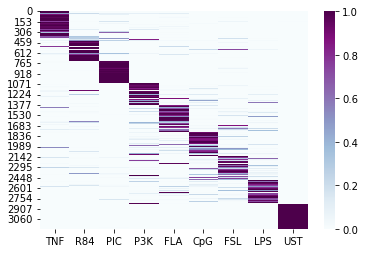

In [48]:
upcf = sns.heatmap(up_fraction, cmap = "BuPu", xticklabels=ligands)
print(f' Accuracy: {sum(up_df[0] == up_df[1])/3200}')
print(up_df)

              precision    recall  f1-score      support
TNF            0.891358  0.918575  0.904762   393.000000
R84            0.908517  0.857143  0.882083   336.000000
PIC            0.909091  0.984615  0.945347   325.000000
P3K            0.859281  0.885802  0.872340   324.000000
FLA            0.844444  0.859296  0.851806   398.000000
CpG            0.874636  0.862069  0.868307   348.000000
FSL            0.825826  0.772472  0.798258   356.000000
LPS            0.861671  0.837535  0.849432   357.000000
UST            0.997253  1.000000  0.998624   363.000000
accuracy       0.885938  0.885938  0.885938     0.885938
macro avg      0.885786  0.886390  0.885662  3200.000000
weighted avg   0.885470  0.885938  0.885295  3200.000000


<AxesSubplot:>

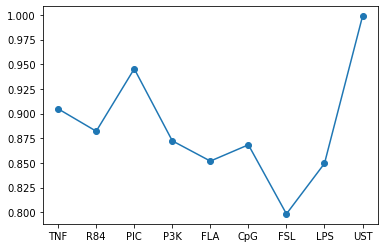

In [49]:
upcf = sklearn.metrics.classification_report(up_df[0], up_df[1], target_names=ligands, output_dict=True)
upcf = pd.DataFrame(upcf).transpose()
print(upcf)

upf1 = upcf[:9]['f1-score']
upf1.plot(y = 'f1-score', style = 'o-')

<h4>ib</h4>

 Accuracy: 0.9315625
        0    1
0     3.0  1.0
1     4.0  4.0
2     3.0  3.0
3     8.0  8.0
4     2.0  2.0
...   ...  ...
3195  0.0  0.0
3196  5.0  5.0
3197  8.0  8.0
3198  4.0  4.0
3199  3.0  3.0

[3200 rows x 2 columns]


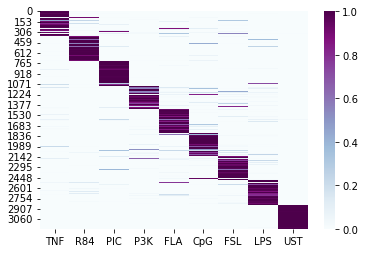

In [50]:
ibcf = sns.heatmap(ib_fraction, cmap = "BuPu", xticklabels=ligands)
print(f' Accuracy: {sum(ib_df[0] == ib_df[1])/3200}')
print(ib_df)

              precision    recall  f1-score      support
TNF            0.965409  0.848066  0.902941   362.000000
R84            0.941176  0.959128  0.950067   367.000000
PIC            0.942105  0.954667  0.948344   375.000000
P3K            0.936170  0.905882  0.920777   340.000000
FLA            0.855670  0.959538  0.904632   346.000000
CpG            0.905488  0.865889  0.885246   343.000000
FSL            0.919771  0.935860  0.927746   343.000000
LPS            0.927273  0.952000  0.939474   375.000000
UST            1.000000  1.000000  1.000000   349.000000
accuracy       0.931562  0.931562  0.931562     0.931562
macro avg      0.932562  0.931226  0.931025  3200.000000
weighted avg   0.932916  0.931562  0.931373  3200.000000


<AxesSubplot:>

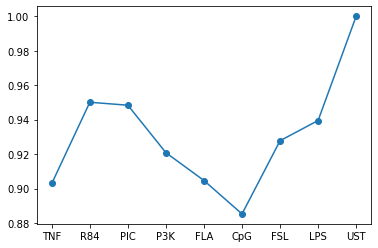

In [51]:
ibcf = sklearn.metrics.classification_report(ib_df[0], ib_df[1], target_names=ligands, output_dict=True)
ibcf = pd.DataFrame(ibcf).transpose()
print(ibcf)

ibf1 = ibcf[:9]['f1-score']
ibf1.plot(y = 'f1-score', style = 'o-')

<h4>ig</h4>

 Accuracy: 0.87375
        0    1
0     7.0  7.0
1     2.0  2.0
2     4.0  4.0
3     3.0  3.0
4     0.0  0.0
...   ...  ...
3195  2.0  2.0
3196  6.0  6.0
3197  6.0  6.0
3198  4.0  4.0
3199  5.0  5.0

[3200 rows x 2 columns]


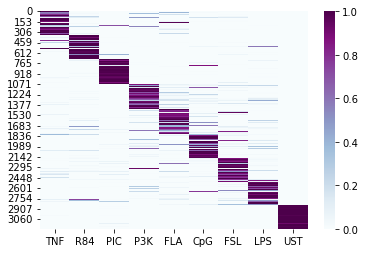

In [52]:
igcf = sns.heatmap(ig_fraction, cmap = "BuPu", xticklabels=ligands)
print(f' Accuracy: {sum(ig_df[0] == ig_df[1])/3200}')
print(ig_df)

              precision    recall  f1-score     support
TNF            0.920635  0.819209  0.866966   354.00000
R84            0.943620  0.871233  0.905983   365.00000
PIC            0.921348  0.934473  0.927864   351.00000
P3K            0.797368  0.839335  0.817814   361.00000
FLA            0.827485  0.766938  0.796062   369.00000
CpG            0.857542  0.850416  0.853964   361.00000
FSL            0.817935  0.875000  0.845506   344.00000
LPS            0.804569  0.916185  0.856757   346.00000
UST            0.997143  1.000000  0.998569   349.00000
accuracy       0.873750  0.873750  0.873750     0.87375
macro avg      0.876405  0.874754  0.874387  3200.00000
weighted avg   0.876324  0.873750  0.873850  3200.00000


<AxesSubplot:>

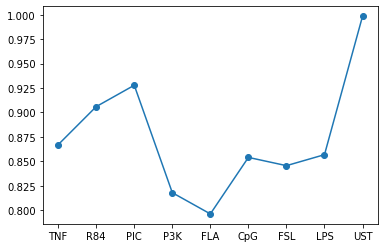

In [53]:
igcf = sklearn.metrics.classification_report(ig_df[0], ig_df[1], target_names=ligands, output_dict=True)
igcf = pd.DataFrame(igcf).transpose()
print(igcf)

igf1 = igcf[:9]['f1-score']
igf1.plot(y = 'f1-score', style = 'o-')

<h4>i0</h4>

 Accuracy: 0.919375
        0    1
0     2.0  2.0
1     2.0  2.0
2     2.0  2.0
3     5.0  5.0
4     5.0  5.0
...   ...  ...
3195  2.0  2.0
3196  4.0  4.0
3197  6.0  6.0
3198  5.0  5.0
3199  2.0  2.0

[3200 rows x 2 columns]


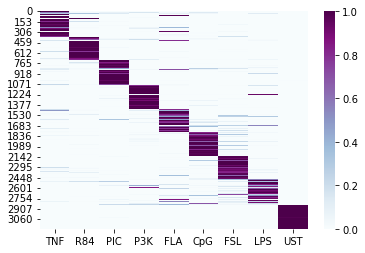

In [54]:
i0cf = sns.heatmap(i0_fraction, cmap = "BuPu", xticklabels=ligands)
print(f' Accuracy: {sum(i0_df[0] == i0_df[1])/3200}')
print(i0_df)

              precision    recall  f1-score      support
TNF            0.936782  0.878706  0.906815   371.000000
R84            0.933735  0.898551  0.915805   345.000000
PIC            0.945355  0.958449  0.951857   361.000000
P3K            0.942149  0.966102  0.953975   354.000000
FLA            0.848315  0.877907  0.862857   344.000000
CpG            0.901099  0.945245  0.922644   347.000000
FSL            0.846154  0.971510  0.904509   351.000000
LPS            0.940252  0.788918  0.857963   379.000000
UST            0.994286  1.000000  0.997135   348.000000
accuracy       0.919375  0.919375  0.919375     0.919375
macro avg      0.920903  0.920599  0.919284  3200.000000
weighted avg   0.921358  0.919375  0.918857  3200.000000


<AxesSubplot:>

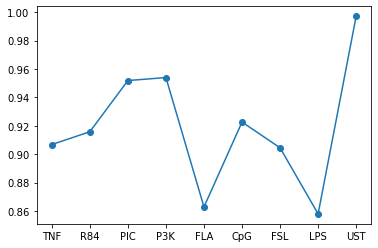

In [55]:
i0cf = sklearn.metrics.classification_report(i0_df[0], i0_df[1], target_names=ligands, output_dict=True)
i0cf = pd.DataFrame(i0cf).transpose()
print(i0cf)

i0f1 = i0cf[:9]['f1-score']
i0f1.plot(y = 'f1-score', style = 'o-')

<h4>i3</h4>

 Accuracy: 0.949375
        0    1
0     7.0  7.0
1     0.0  0.0
2     2.0  2.0
3     6.0  6.0
4     7.0  7.0
...   ...  ...
3195  4.0  4.0
3196  8.0  8.0
3197  7.0  1.0
3198  1.0  1.0
3199  7.0  7.0

[3200 rows x 2 columns]


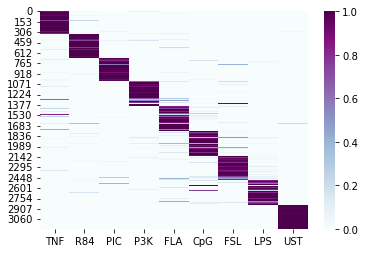

In [56]:
i3cf = sns.heatmap(i3_fraction, cmap = "BuPu", xticklabels=ligands)
print(f' Accuracy: {sum(i3_df[0] == i3_df[1])/3200}')
print(i3_df)

              precision    recall  f1-score      support
TNF            0.932203  0.970588  0.951009   340.000000
R84            0.959064  0.964706  0.961877   340.000000
PIC            0.940217  0.985755  0.962448   351.000000
P3K            0.956012  0.895604  0.924823   364.000000
FLA            0.941989  0.941989  0.941989   362.000000
CpG            0.937500  0.924933  0.931174   373.000000
FSL            0.916898  0.951149  0.933709   348.000000
LPS            0.963173  0.916442  0.939227   371.000000
UST            1.000000  1.000000  1.000000   351.000000
accuracy       0.949375  0.949375  0.949375     0.949375
macro avg      0.949673  0.950130  0.949584  3200.000000
weighted avg   0.949731  0.949375  0.949234  3200.000000


<AxesSubplot:>

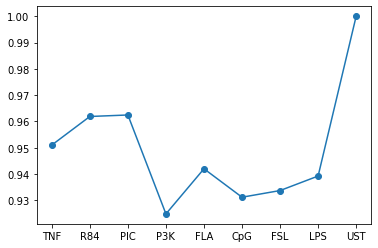

In [57]:
i3cf = sklearn.metrics.classification_report(i3_df[0], i3_df[1], target_names=ligands, output_dict=True)
i3cf = pd.DataFrame(i3cf).transpose()
print(i3cf)

i3f1 = i3cf[:9]['f1-score']
i3f1.plot(y = 'f1-score', style = 'o-')

<h4>i4</h4>

        0    1
0     2.0  2.0
1     0.0  3.0
2     0.0  0.0
3     6.0  6.0
4     8.0  8.0
...   ...  ...
3195  4.0  4.0
3196  0.0  0.0
3197  3.0  3.0
3198  2.0  2.0
3199  4.0  4.0

[3200 rows x 2 columns]
 Accuracy: 0.9478125


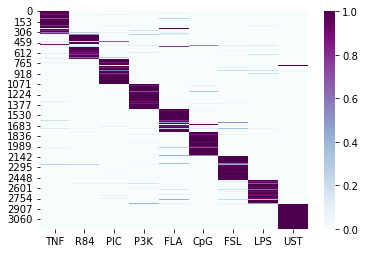

In [58]:
i4cf = sns.heatmap(i4_fraction, cmap = "BuPu", xticklabels=ligands)
print(i4_df)
print(f' Accuracy: {sum(i4_df[0] == i4_df[1])/3200}')

              precision    recall  f1-score      support
TNF            0.946875  0.899110  0.922374   337.000000
R84            0.976261  0.921569  0.948127   357.000000
PIC            0.907960  0.963061  0.934699   379.000000
P3K            0.950820  0.974790  0.962656   357.000000
FLA            0.887097  0.945559  0.915395   349.000000
CpG            0.940171  0.962099  0.951009   343.000000
FSL            0.961194  0.912181  0.936047   353.000000
LPS            0.974790  0.948229  0.961326   367.000000
UST            0.994444  1.000000  0.997214   358.000000
accuracy       0.947812  0.947812  0.947812     0.947812
macro avg      0.948846  0.947400  0.947650  3200.000000
weighted avg   0.948849  0.947812  0.947857  3200.000000


<AxesSubplot:>

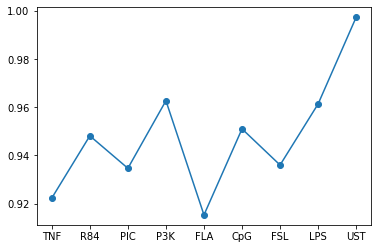

In [59]:
i4cf = sklearn.metrics.classification_report(i4_df[0], i4_df[1], target_names=ligands, output_dict=True)
i4cf = pd.DataFrame(i4cf).transpose()
print(i4cf)

i4f1 = i4cf[:9]['f1-score']
i4f1.plot(y = 'f1-score', style = 'o-')

### Holistic Eval

In [60]:
total_f1 = pd.concat([upf1, ibf1, igf1, i0f1, i3f1, i4f1], axis=1)

In [61]:
total_f1 = total_f1.set_axis(['upf1', 'ibf1', 'igf1', 'i0f1', 'i3f1', 'i4f1'], axis=1)
print(total_f1)

         upf1      ibf1      igf1      i0f1      i3f1      i4f1
TNF  0.904762  0.902941  0.866966  0.906815  0.951009  0.922374
R84  0.882083  0.950067  0.905983  0.915805  0.961877  0.948127
PIC  0.945347  0.948344  0.927864  0.951857  0.962448  0.934699
P3K  0.872340  0.920777  0.817814  0.953975  0.924823  0.962656
FLA  0.851806  0.904632  0.796062  0.862857  0.941989  0.915395
CpG  0.868307  0.885246  0.853964  0.922644  0.931174  0.951009
FSL  0.798258  0.927746  0.845506  0.904509  0.933709  0.936047
LPS  0.849432  0.939474  0.856757  0.857963  0.939227  0.961326
UST  0.998624  1.000000  0.998569  0.997135  1.000000  0.997214


<AxesSubplot:>

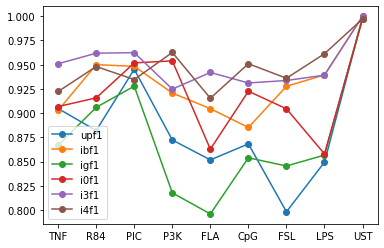

In [63]:
total_f1.plot(style = 'o-')